In [1]:
import os
os.chdir('/Users/amandabuch/Documents/clusterCCA/revision1/clusterCCA')
from pcmf import path_plot, plot_cluster_assignments, two_cluster_data, pcmf_full
from p3ca import cluster_metrics, calculate_scores_nonpath
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning')

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import normalized_mutual_info_score
from scipy.stats import multivariate_normal
from collections import OrderedDict

import time
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linprog
from scipy.optimize import linear_sum_assignment as linear_assignment
import seaborn as sns; sns.set()
import numpy as np
os.chdir('/Users/amandabuch/Documents/clusterCCA/revision1/clusterCCA/utils/subspace-clustering-master')
from cluster.selfrepresentation import ElasticNetSubspaceClustering


os.chdir('/Users/amandabuch/Documents/clusterCCA/revision1/clusterCCA')
from pcmf import sparse_D, get_weights
from pcmf import cluster_path, select_fit, cluster_fit

from pcmf import pcmf_full, pcmf_approx_uV, pcmf_full_consensus, save_multi_image, two_cluster_data, generate_cluster_PMD_data

from sklearn.utils.extmath import randomized_svd

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import matplotlib.cm as cm

import cvxpy as cp

import matplotlib

from itertools import combinations 
from numba import jit, prange


In [2]:

@jit(nopython=True, parallel=True, fastmath=True)
def prox_numba_arr(V_prox, V, lamb, rho, w=None):
    '''
    Numba formulation of Proximal operator for group sparse thresholding.
    '''
#     print(V_prox)
#     print(w)
    if w is None:
        w = np.ones(V.shape[0])
    for i in prange(V.shape[0]):
        if np.isinf(lamb):
            alpha = lamb/rho
        else:
            alpha = w[i]*lamb/rho
#         print(alpha)
        # group_soft_threshold
        vec_norm = np.linalg.norm(V[i,:])
#         print(alpha)
        if vec_norm > alpha:
#             print(vec_norm > alpha)
            V_prox[i, :] = V[i,:] - alpha*V[i,:]/vec_norm
        else:
            V_prox[i, :] = np.zeros_like(V[i,:])
#     print(V_prox)
    return V_prox
@jit(nopython=True, parallel=True, fastmath=True) 
def nb_subtract(M1, M2):
    return M1-M2

@jit(nopython=True, parallel=True, fastmath=True)
def nb_add(M1, M2):
    return M1+M2

def get_weights(X, gauss_coef=0.5, neighbors=None):
    from scipy.spatial.distance import pdist, squareform
    dist_vec = pdist(X) / X.shape[0]
    w = np.exp(-1*gauss_coef*(dist_vec)**2)
    if neighbors is not None:
        from sklearn.neighbors import NearestNeighbors
        nbrs = NearestNeighbors(n_neighbors=neighbors, algorithm='ball_tree').fit(X)
        _, indices = nbrs.kneighbors(X)
        comb_list = list(combinations(range(X.shape[0]),2))
        neighbors_indicator = []
        for comb in comb_list:
            nn_i = indices[comb[0],:]
            if comb[1] in nn_i:
                neighbors_indicator.append(1.0)
            else:
                neighbors_indicator.append(0.0)
        w *= np.array(neighbors_indicator)
    return w

def l2_ball_proj(X):
    '''
    Normalize rows of X to satisfy $\|X_{i,\cdot}\|_2^2 \leq 1$.
    '''
    def row_norm(vec): 
        return np.sqrt(1./np.sum(vec**2)) * vec
    return np.apply_along_axis(row_norm,1,X)

def SVD(X,return_rank=2):
    U, s, Vh = np.linalg.svd(X,full_matrices=False)
    U = U[:,0:return_rank]
    Vh = Vh[0:return_rank,:]
    s = s[0:return_rank]
    return U,s,Vh

def NMF(X,return_rank=2):
    from sklearn.decomposition import NMF as sk_NMF
    model = sk_NMF(n_components=return_rank, init='random', random_state=0)
    U = model.fit_transform(X)
    Vh = model.components_
    U = U[:,0:return_rank]
    Vh = Vh[0:return_rank,:]
    return U,Vh


from scipy.sparse import csr_matrix
from sksparse.cholmod import cholesky, cholesky_AAt
def sparse_D(n,p):
    '''
    Construct a sparse matrix, that when applied to a vector containing concatenated vectors
    of coefficients b = [b_1 b_2 ... b_n] where each b_i is p=num_var long and there are 
    n = num_vec of them. Differences are taken between conformal elements (e.g. b_11 and b_21)
    across all unique pairwise combinations of vectors. 
    '''
    comb_list = list(combinations(range(n),2))
    combs_arr = np.array(comb_list)
    num_combs = combs_arr.shape[0]
    data = np.ones_like(combs_arr)
    data[:,1] *= -1
    row = np.repeat(range(num_combs),2)
    col = combs_arr.flatten()
    return csr_matrix((data.flatten(), (row, col)), shape=(num_combs, n))

def chol_D(num_obs, num_vars, rho, reg_scale=1.0):
    D = sparse_D(num_obs, num_vars)
    return D, cholesky_AAt(np.sqrt(rho) * D.T, beta=1.0*reg_scale)

def group_soft_threshold(vec,alpha):
    if np.linalg.norm(vec) > alpha:
        return vec - alpha*vec/np.linalg.norm(vec) 
    else:
        return np.zeros_like(vec)
    
def prox(V, lamb, rho, w=None):
    '''
    Proximal operator for group sparse thresholding.
    '''
    if w is None:
        w = np.ones(V.shape[0])
    V_prox = []
    for i in range(V.shape[0]):
        alpha = w[i]*lamb/rho
        V_prox.append(group_soft_threshold(V[i,:],alpha))
    return np.asarray(V_prox)  

def l2_ball_proj(X):
    '''
    Normalize rows of X to satisfy $\|X_{i,\cdot}\|_2^2 \leq 1$.
    '''
    def row_norm(vec): 
        return np.sqrt(1./np.sum(vec**2)) * vec
    return np.apply_along_axis(row_norm,1,X)

def objective_fn(X, beta, lambd, l2_reg, num_var, num_obs, min_path_X=None, reg_type='group'):
    if lambd.value == 0:
        mat = loss_fn(X, beta) + l2_reg*cp.norm2(beta)**2
    else:
        if reg_type == 'group':
            if min_path_X is None:
                reg = group_regularizer(beta, num_var, num_obs)
            else:
                reg = group_regularizer_approx(beta, num_var, num_obs, min_path_X)
        elif reg_type == 'L1':
            reg = L1_regularizer(beta, num_var, num_obs)
        else:
            return ValueError('reg_type value error')
        mat = loss_fn(X, beta) + lambd*reg + l2_reg*cp.norm2(beta)**2
    return mat

def objective_fn_u(X, beta):
    mat = loss_fn(X, beta)
    return mat

def objective_fn_u2(X, beta, penalty):
    D = sparse_D(X.shape[0],1)
    mat = loss_fn(X, beta) + penalty*cp.norm2(D@beta)
    return mat

from sklearn.utils.extmath import randomized_svd
def pcmf_full_consensus_its(X_all, penalty_list, problem_rank=1, rho=1.0, admm_iters = 5, verb=False, weights=False, neighbors=None, gauss_coef=2.0,print_progress=True, parallel=False, output_file='NaN',factor_type='SVD', split_size=10):
    '''
    Fits fully constrained PCMF problem iterating between convex clustering and an SVD of rank 'problem_rank' 
    using ADMM updates.
    '''
    print('weights: '+str(weights), 'neighbors: '+str(neighbors), 'gauss_coef: '+str(gauss_coef), 'rho: '+str(rho))
    #
    rho1 = rho2 = rho
#     rho1 = rho - 0.02
#     rho2 = rho

    print("rho1:",rho1,"rho2",rho2)
    # Data split
    X_list = np.array_split(X_all, int(X_all.shape[0]/split_size), axis=0) # get batches
    X_list_inds = np.array_split(np.arange(X_all.shape[0]), int(X_all.shape[0]/split_size), axis=0) # get batches
    X = X_list[0]
    num_obs = X.shape[0]
    num_var = X.shape[1]
    D, chol_factor = chol_D(num_obs, num_var, rho1, reg_scale=1.0+rho1) # note num_var is not used in chol_D
    print("Number of batches:",len(X_list))
    #
    # Initialize
    G = []
    A = []
    Z1 = []
    Z2 = []
    U = []
    Vh = []
    s = []
    X_mean = []
    weights_list = []
    for X, idx in zip(X_list, np.arange(len(X_list))):
        print("Initialize IDX:",idx)
        X_mean.append(X.mean(0))
        X = X-np.mean(X,axis=0)
        X_list[idx] = X
        if weights is False:
            weights = get_weights(X,gauss_coef=0.0)
        else:
            weights = get_weights(X,gauss_coef=gauss_coef, neighbors=neighbors)
        weights_list.append(weights)
        #
        Ginit = Z1init = D*X
        Ainit = Z2init = X.copy()
        G.append(Ginit)
        A.append(Ainit)
        Z1.append(Z1init)
        Z2.append(Z2init)
    #
    M = []
    for X, idx in zip(X_list, np.arange(len(X_list))):
        M.append(np.tile(X_mean[idx],(X_list[0].shape[0],1)))
    M = np.vstack(M)
    print("Means matrix has shape:", M.shape)
#     print(M)
    
#     U, s, Vh = SVD(X_all, problem_rank)
    U, s, Vh = randomized_svd(X_all, n_components=problem_rank,random_state=1234)
    for X, idx in zip(X_list, np.arange(len(X_list))):
        X_inds = X_list_inds[idx]
#         Z2[idx] = X_all[X_inds,:] #np.dot(U[X_inds]*s,Vh)
        Z2[idx] = X.copy() #np.dot(U[X_inds]*s,Vh)
    #
    A_list_its = []
    G_list_its = []
    Z1_list_its = []
    Z2_list_its = []
    A_list = []
    U_list = []
    s_list = []
    V_list = []
    G_list = []
    Z1_list = []
    Z2_list = []
    #
    try:
        # Iterate over penalty grid fitting problem for each value
        for i in range(len(penalty_list)):
            penalty = penalty_list[i]
            num_obs = X.shape[0]
            num_var = X.shape[1]
            if print_progress == True:
                if parallel == True:
                    file1 = open(output_file, "a")
                    file1.write(str([i+1])+" {:.5e}".format(penalty))
                    file1.write("...")
                    file1.close()
                else:                                                     
                    print("[",i+1,"]","{:.5e}".format(penalty), end="")
                    print("...", end="")
            for it in range(admm_iters):
                for X, idx in zip(X_list, np.arange(len(X_list))):
                    X_inds = X_list_inds[idx]
                    A[idx] = chol_factor(X + rho*D.T*(G[idx] - Z1[idx]) + rho*(np.dot(U[X_inds]*s,Vh) - Z2[idx]))
                    G[idx] = prox_numba_arr(np.zeros_like(G[idx]), D*A[idx]+Z1[idx], penalty, rho1, weights_list[idx])
                #
                # consensus
                As = np.vstack(A)
                Z2s = np.vstack(Z2)
#                 U, s, Vh = SVD(As + Z2s, problem_rank)
#                 print("Vh.shape:",Vh.shape)
#                 print("Vh:",Vh[0,0:3])
                B = As + Z2s
#                 U_b, s_b, Vh_b = SVD(B, problem_rank)
                U_b, s_b, Vh_b = randomized_svd(B, n_components=problem_rank,random_state=1234)
                U_a__s_a = np.dot(B + M, Vh_b.T)
#                 print("Vh_b:",Vh_b[0,0:3])
#                 print("U before:",U[0:3,0].T)
                Vh = Vh_b
                s = s_b
                U = U_a__s_a / s
                U = np.sqrt(1./np.sum(U**2)) * U
#                 print("U_a__s_a:",U_a__s_a[0:3,0].T)
#                 print("U after:",U[0:3,0].T)
                #
                Z2_update = rho2*(As - np.dot(U*s,Vh))
                #
                for X, idx in zip(X_list, np.arange(len(X_list))):
                    X_inds = X_list_inds[idx]
                    Z1[idx] = Z1[idx] + rho1*(D*A[idx] - G[idx])
                    Z2[idx] = Z2[idx] + Z2_update[X_inds,:] # should this be Z2_update[X_inds,:]?
#                     Z2[idx] = Z2[idx] + Z2_update[X_inds] # should this be Z2_update[X_inds,:]?
                A_list_its.append(np.vstack(A))
                G_list_its.append(np.vstack(G))
                Z1_list_its.append(np.vstack(Z1))
                Z2_list_its.append(np.vstack(Z2))

            A_list.append(np.vstack(A))
            V_list.append(np.vstack(Vh))
            s_list.append(np.vstack(s))
            U_list.append(np.vstack(U))
            G_list.append(np.vstack(G))
            Z1_list.append(np.vstack(Z1))
            Z2_list.append(np.vstack(Z2))
            
    except KeyboardInterrupt:
        print("KeyboardInterrupt has been caught.")
        
    return A_list, U_list, s_list, V_list, G_list, Z1_list, Z2_list, A_list_its, G_list_its, Z1_list_its, Z2_list_its


def pcmf_approx_uV_its(X, penalty_list, rho=1.0, admm_iters = 5, pals_admm=False, verb=False, weights=False, neighbors=None, gauss_coef=0.5,  print_progress=True, parallel=False, output_file='NaN', non_negative=False, numba=False):
    '''
    Relaxation of full PCMF problem to iterate between clustering on u and clustering on V. 
    '''
    print('weights: '+str(weights), 'neighbors: '+str(neighbors), 'gauss_coef: '+str(gauss_coef), 'rho: '+str(rho))
    # Initialize                                                                                                     
    if weights is False:
        weights = get_weights(X,gauss_coef=0.0)
    else:
        weights = get_weights(X,gauss_coef=gauss_coef, neighbors=neighbors)
    D, chol_factor = chol_D(X.shape[0], X.shape[1], rho)
    V = X.copy()
    for i in range(V.shape[0]):
        V[i,:] = np.mean(X,axis=0)
    W = Z = D*X
    d = np.ones(X.shape[0])
    V_list = []
    u_list = []
    s_list = []
    W_list = []
    Z_list = []
    W2_list = []
    Z2_list = []
    Xu_list = []
    Xv_list = []
    u_list_its = []
    V_list_its = []
    Z_list_its = []
    Z2_list_its = []

    # First run initial on v_init                                                                                    
    Xu_tildes = []
    
    for i in range(X.shape[0]):
        Xu_tildes.append([np.dot(X[i,:],np.ones_like(V[i,:]))])

    Xu = np.asarray(Xu_tildes)

    W2 = Z2 = D*Xu
    # ADMM u update
    for it in range(admm_iters):
        # Chol factor update
        u = chol_factor(Xu + rho*D.T*(W2 - Z2)) # 
        # (Weighted) Consensus Penalty update
        W2 = prox_numba_arr(np.zeros_like(W2),D*u+Z2, penalty_list[0], rho, np.ones_like(weights)) #
        # Dual update
        Z2 = Z2 + D*u - W2
    u = np.sqrt(1./np.sum(u**2)) * u 

    try:
        # Iterate over penalty grid fitting problem for each value
        for i in range(len(penalty_list)):
            penalty = penalty_list[i]
            num_obs = X.shape[0]
            num_var = X.shape[1]
            if print_progress == True:
                if parallel == True:
                    file1 = open(output_file, "a")
                    file1.write(str([i+1])+" {:.5e}".format(penalty))
                    file1.write("...")
                    file1.close()
                else:
                    print("[",i+1,"]","{:.5e}".format(penalty), end="")
                    print("...", end="")

            # Update V                                                                                                   
            Xv_tildes = []
            for i in range(X.shape[0]):
                Xv_tildes.append(u[i]*X[i,:])
            Xv = np.asarray(Xv_tildes)
            for it in range(admm_iters):
                if numba is False:
                    V = chol_factor(Xv + rho*D.T*(W - Z))
        #            W_prev = W.copy()
                    W = cprox(D*V+Z, penalty, rho, weights)
                else:
                    V = chol_factor(nb_add(Xv, rho*D.T*nb_subtract(W,Z)))
                    W = prox_numba_arr(np.zeros_like(W), D*V+Z, penalty, rho, weights)

                Z = Z + D*V - W
                V_list_its.append(V)
                Z_list_its.append(Z)
                
            V = l2_ball_proj(V)
            if non_negative:
                V[V<0] = 0
            V_list.append(V)
            W_list.append(W)
            Z_list.append(Z)
            Xv_list.append(Xv)

            # Update u    
            if pals_admm == True:
                # Update u                                                                                                   
                Xu_tildes = []
                for i in range(X.shape[0]):
                    Xu_tildes.append([np.dot(X[i,:],np.ones_like(V[i,:]))])
                Xu = np.asarray(Xu_tildes)
                    # ADMM u update
                for it in range(admm_iters):
                    # Chol factor update
                    u = chol_factor(Xu + rho*D.T*(W2 - Z2)) # 
                    # (Weighted) Consensus Penalty update
                    W2 = prox_numba_arr(np.zeros_like(W2),D*u+Z2, penalty, rho, np.ones_like(weights)) #
                    # Dual update
                    Z2 = Z2 + D*u - W2
                    u_list_its.append(u)
                    Z2_list_its.append(Z2 + D*u - W2)
                u = np.sqrt(1./np.sum(u**2)) * u

#                 Xu_tildes = []
#                 for i in range(X.shape[0]):
#                     Xu_tildes.append([np.dot(X[i,:],np.ones_like(V[i,:]))])
#     #                 Xu_tildes.append([np.dot(X[i,:],X[i,:])]) # try with many u admm_iters
# #                     Xu_tildes.append(np.dot(X[i,:],V[i,:]))
#                 Xu = np.asarray(Xu_tildes)
#                     # ADMM u update
#                 for it in range(admm_iters):
#                     # Chol factor update
#                     u = np.atleast_2d(chol_factor(Xu + rho*D.T*(W2 - Z2))).T # 
#                     print('u shape',u.shape)
#                     # (Weighted) Consensus Penalty update
#                     W2 = prox_numba_arr(np.zeros_like(W2),D*u+Z2, penalty, rho, np.ones_like(weights)) #
#                     # Dual update
#                     Z2 = Z2 + D*u - W2
#                 u = np.sqrt(1./np.sum(u**2)) * u
#                 print('u shape',u.shape)
#                 s = u*Xv
                W2_list.append(W2)
                Z2_list.append(Z2)
                Xu_list.append(Xu)
            else:
                # Update u                                                                                                   
                Xu_tildes = []
                for i in range(X.shape[0]):
                    Xu_tildes.append(np.dot(X[i,:],V[i,:]))
                Xu = np.asarray(Xu_tildes)
                try:
                    u = clusterpath_PCMF_subproblem_u(Xu_tildes, 1, penalty, verb)
                except:
                    print("PCMF subproblem is not defined for single cluster u, using PMD subproblem.")
                    u = clusterpath_PMD_subproblem_u(Xu_tildes, 1, verb)
                u.shape = (len(u),1)
                s = u*Xv

            u_list.append(u)
            s_list.append(d)

    except KeyboardInterrupt:
        print("KeyboardInterrupt has been caught.")

    return V_list, u_list, s_list, W_list, W2_list, Z_list, Z2_list, Xv_list, Xu_list, u_list_its, V_list_its, Z_list_its, Z2_list_its

###################### ADMM subproblems for u #######################
def clusterpath_PMD_subproblem_u(X_list, num_var, verb=True):
    '''
    Solves one subproblem in the alternating PMD-like pathwise clustered algorithm 
    for one value of lambda. Does not directly cluster u's.

    Note: we may want to relax convergence criteria for subproblem (at least in early iterations).
    '''
    X = np.hstack(X_list) # XXX add check - vector num_var*num_obs long
    num_obs = int(len(X)/num_var)
    beta = cp.Variable(num_var*num_obs)
    lambd = cp.Parameter(nonneg=True)
    l2_reg = cp.Parameter(nonneg=True)
    constraints = [cp.norm2(beta)**2 <= 1] 
    problem = cp.Problem(cp.Minimize(objective_fn_u(X, beta)), constraints)

    mosek_params = {} #{'MSK_DPAR_MIO_TOL_ABS_GAP':1e-1}
    problem.solve(solver='MOSEK',verbose=verb, warm_start=True, mosek_params=mosek_params)
    #err = mse(X, beta)
    return beta.value #, err

def clusterpath_PCMF_subproblem_u(X_list, num_var, penalty, verb=True):
    '''
    Solves one subproblem in the alternating PCMF pathwise clustered algorithm                                    
    for one value of lambda.

    Note: we may want to relax convergence criteria for subproblem (at least in early iterations).                       '''
    X = np.hstack(X_list) # XXX add check - vector num_var*num_obs long
    num_obs = int(len(X)/num_var)
    beta = cp.Variable(num_var*num_obs)
    lambd = cp.Parameter(nonneg=True)
    l2_reg = cp.Parameter(nonneg=True)
    constraints = [cp.norm2(beta)**2 <= 1]
    problem = cp.Problem(cp.Minimize(objective_fn_u2(X, beta, penalty)), constraints)
    mosek_params = {} #{'MSK_DPAR_MIO_TOL_ABS_GAP':1e-1}                                  
    problem.solve(solver='MOSEK',verbose=verb, warm_start=True, mosek_params=mosek_params)
    #err = mse(X, beta)                                                                    
    return beta.value #, err

def loss_fn(X, beta):
    return -1*cp.sum(cp.matmul(X,beta))

def mse(X, beta):
    return (1.0 / X.shape[0]) * loss_fn(X, beta).value


In [3]:
def plot_dendrogram(Xhat,problem_rank,true_clusters_all,n_infinities,penalty_list,ylabel=False):
    from pcmf import centroid_matrix
    Xhat_centroids = []
    for p in range(len(penalty_list)):
        Xhat_centroids.append(centroid_matrix(np.array(Xhat[p]),true_clusters_all))
    path_plot(np.asarray(Xhat_centroids)[:,:,0:1], penalty_list, plot_range=[n_infinities,-1])
    if ylabel==False:
        plt.ylabel("$\hat{X}$ Rank "+str(problem_rank))
    else:
        plt.ylabel(ylabel)
    plt.locator_params(axis='x',nbins=25)
    ax = plt.gca()
    ax.patch.set_facecolor('white')
    plt.grid(b=None)
    fig = plt.gcf()
    fig.set_figheight(3)

# Generate Data

In [5]:
n_clusters = 5
r=1
m=10
num_vars=10
print('run: '+str(r))
seeds = r
# means=[-1.5, 1.5, -1.0, 1.0, -0.4]
means=[-1.5, 1.5,0,0.01, -0.4]
ms = [m,m,m,m,m]
sigma=0.075
density=1

# Get clustered CCA data
X_clusters, u_true, v_true, _=generate_cluster_PMD_data(ms, num_vars, sigma, density, n_clusters, means=means) 
X_c=np.vstack(X_clusters)
true_clusters=np.repeat([0,1,2,3,4],m)
np.random.seed(seed=1234)
# idx_perm=np.random.permutation(X_c.shape[0])
# X_all=X_c[idx_perm,:]
# true_clusters_all=true_clusters[idx_perm]
#
X_all=X_c
true_clusters_all=true_clusters
X_all = np.hstack((X_all,np.ones((X_all.shape[0],1))))

X = X_all
true_clusters = true_clusters_all



run: 1


# ADMM 15 iterations

## PCMF ADMM

In [7]:
pcmf_type='pcmf_admm'
rho=1.0
weights='Gaussian'
gauss_coef=5.0
neighbors=25
admm_iters=15
n_infinities=10
penalty_list=np.concatenate((np.repeat(np.inf,n_infinities), np.exp(np.linspace(-10,10,50))[::-1]), axis=0)
split_size=X_all.shape[0]
parallel=False
save_path='nan'
max_rank = 10

As = []
Us = []
Ss = []
Vs = []
Gs = []
Z1s = []
Z2s = []
As_its = []
Gs_its = []
Z1s_its = []
Z2s_its = []
for problem_rank in range(1,max_rank):
    print('Problem rank '+str(problem_rank))
    tic=time.time()
    A, U, S, V, G, Z1, Z2, A_its, G_its, Z1_its, Z2_its = pcmf_full_consensus_its(X_all, penalty_list, split_size=split_size, rho=rho, admm_iters=admm_iters, weights=weights, gauss_coef=gauss_coef, problem_rank=problem_rank, neighbors=neighbors, print_progress=True, parallel=parallel, output_file=save_path+'.txt')
    As.append(A)
    Us.append(U)
    Ss.append(S)
    Vs.append(V)
    Gs.append(G)
    Z1s.append(Z1)
    Z2s.append(Z2)
    As_its.append(A_its)
    Gs_its.append(G_its)
    Z1s_its.append(Z1_its)
    Z2s_its.append(Z2_its)
    toc=time.time() - tic

Problem rank 1
weights: Gaussian neighbors: 25 gauss_coef: 5.0 rho: 1.0
rho1: 1.0 rho2 1.0
Number of batches: 1
Initialize IDX: 0
Means matrix has shape: (50, 11)
[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 2.20265e+04...[ 12 ] 1.46447e+04...[ 13 ] 9.73686e+03...[ 14 ] 6.47375e+03...[ 15 ] 4.30420e+03...[ 16 ] 2.86174e+03...[ 17 ] 1.90268e+03...[ 18 ] 1.26504e+03...[ 19 ] 8.41086e+02...[ 20 ] 5.59213e+02...[ 21 ] 3.71804e+02...[ 22 ] 2.47202e+02...[ 23 ] 1.64357e+02...[ 24 ] 1.09276e+02...[ 25 ] 7.26544e+01...[ 26 ] 4.83058e+01...[ 27 ] 3.21171e+01...[ 28 ] 2.13537e+01...[ 29 ] 1.41974e+01...[ 30 ] 9.43945e+00...[ 31 ] 6.27601e+00...[ 32 ] 4.17273e+00...[ 33 ] 2.77433e+00...[ 34 ] 1.84457e+00...[ 35 ] 1.22640e+00...[ 36 ] 8.15396e-01...[ 37 ] 5.42132e-01...[ 38 ] 3.60448e-01...[ 39 ] 2.39651e-01...[ 40 ] 1.59337e-01...[ 41 ] 1.05938e-01...[ 42 ] 7.04353e-02...[ 43 ] 4.68303e-02...[ 44 ] 3.11361e-02...[ 

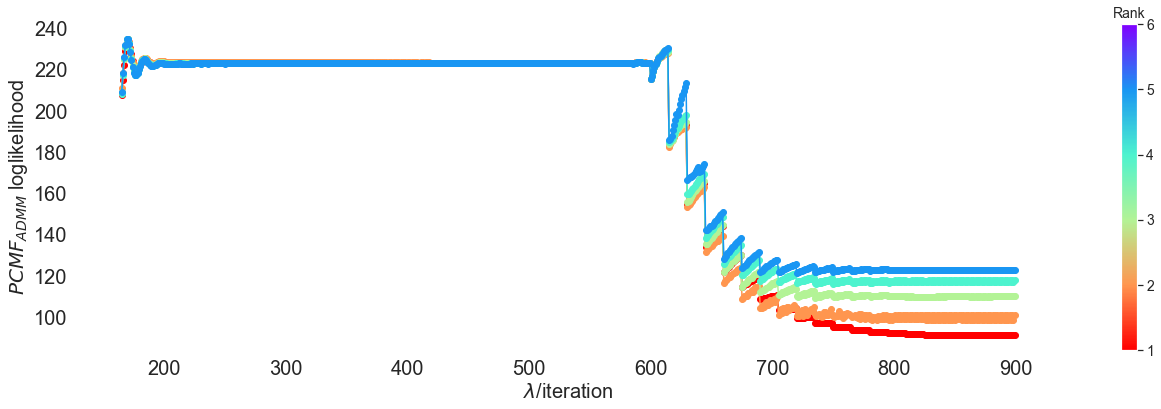

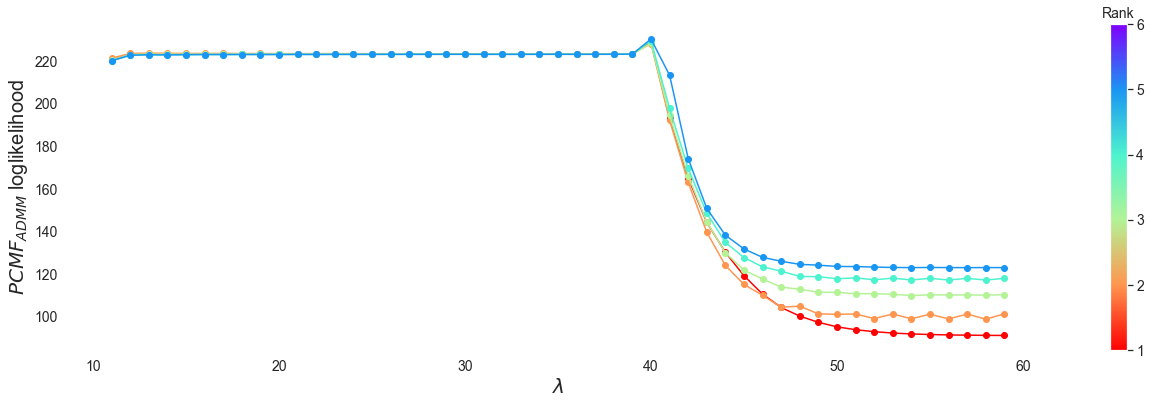

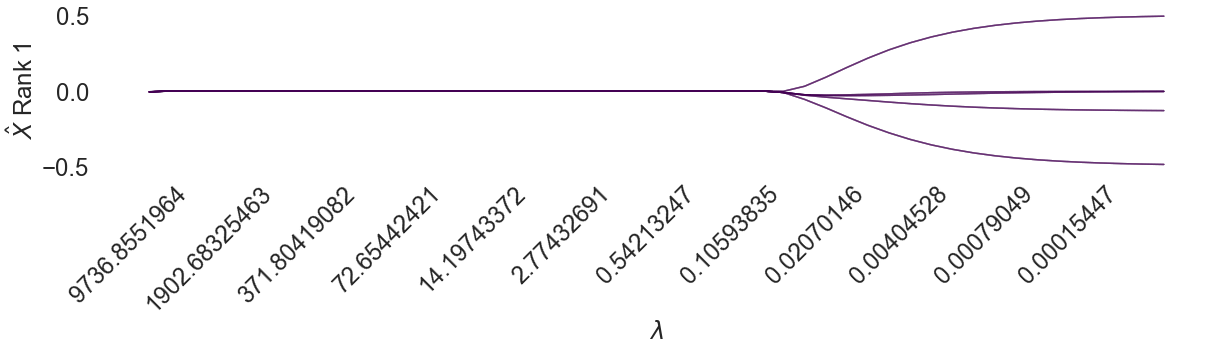

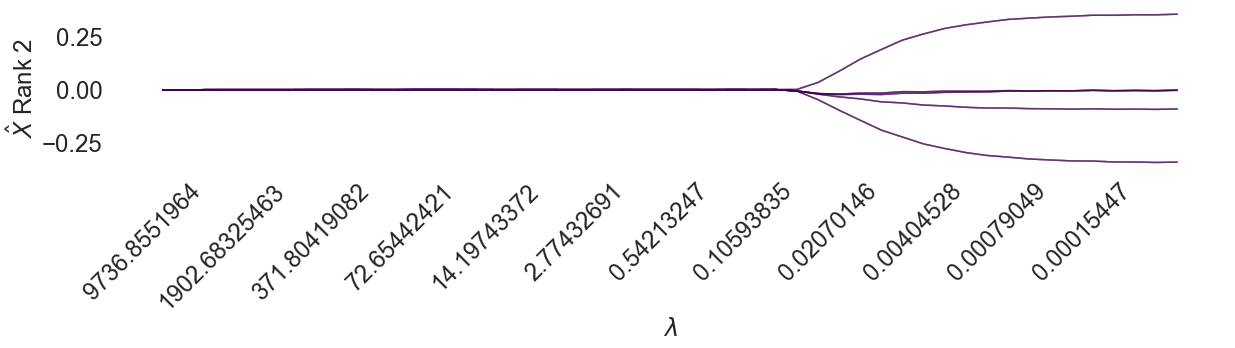

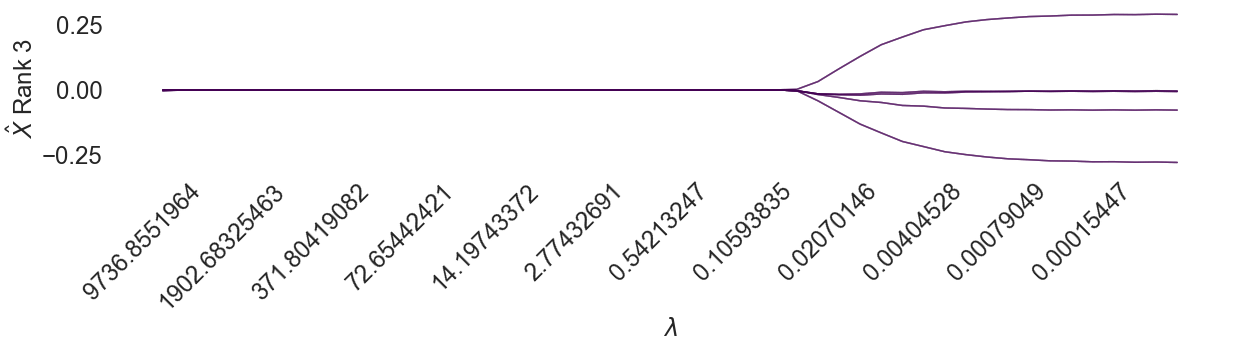

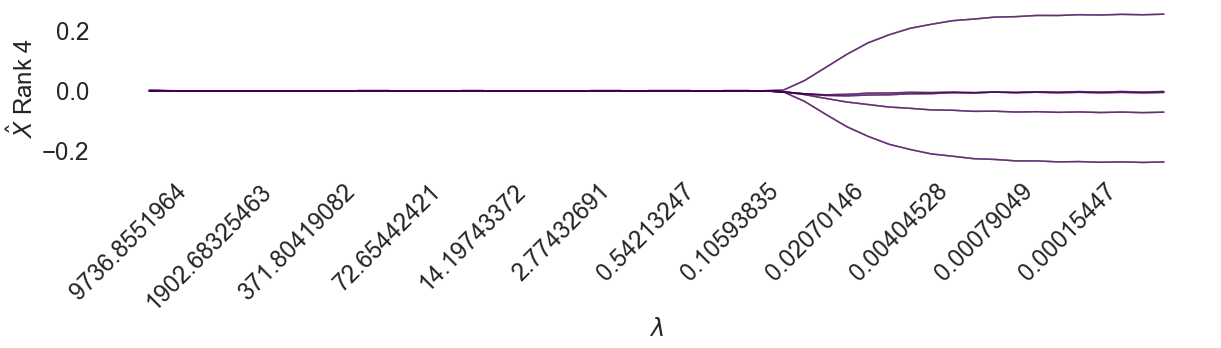

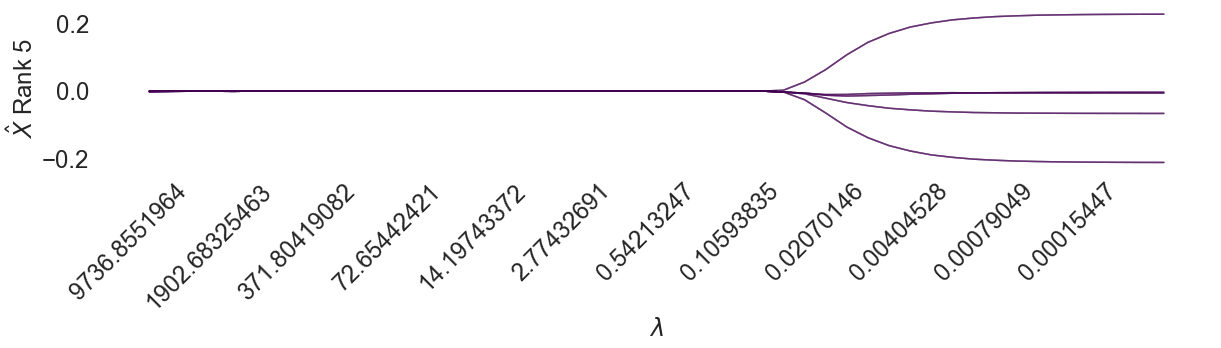

In [8]:
fontsize=20

fig = plt.figure(figsize=(22,6))
ax = fig.add_subplot(111)
ax.patch.set_facecolor('white')
plt.xlabel('$\lambda$/iteration',fontsize=20)
plt.ylabel('$PCMF_{ADMM}$ loglikelihood',fontsize=20)
plt.grid(b=None)
colors = cm.rainbow(np.linspace(1, 0, max_rank))
c = 0

for A,G,Z1,Z2 in zip(As_its,Gs_its,Z1s_its,Z2s_its):
    P_list = []
    k_min = (n_infinities+1)*admm_iters; k_max = len(A)
    for k in np.arange(k_min,k_max,1):
        Xhat = A[k]
        Z1in = Z1[k]
        Z2in = Z2[k]
        penalty = penalty_list[int(np.floor(k / admm_iters))]
        P_list.append(np.linalg.norm(X -Xhat, 2)**2 + np.sum(np.sum(np.abs(Z1in), axis=1)) + np.sum(np.sum(np.abs(Z2in), axis=1)) )# np.linalg.norm(Z1in, 2)**2 + np.linalg.norm(Z2in, 2)**2)
    P = np.asarray(P_list)
    s = plt.plot(np.arange(k_min,k_max,1), P,'o-',color=colors[c,:])
    c = c+1

plt.xticks(fontsize=fontsize,rotation=0);
plt.yticks(fontsize=fontsize,rotation=0);
fontsize=14
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('colors',colors)
sm = plt.cm.ScalarMappable(cmap=mymap, norm=plt.Normalize(vmin=1, vmax=max_rank ))
cbar = plt.colorbar(sm)
cbar.ax.set_title('Rank', rotation=0, fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)


fig = plt.figure(figsize=(22,6))
ax = fig.add_subplot(111)
ax.patch.set_facecolor('white')
plt.xlabel('$\lambda$',fontsize=20)
plt.ylabel('$PCMF_{ADMM}$ loglikelihood',fontsize=20)
plt.grid(b=None)
c = 0

for A,Z1,Z2 in zip(As,Z1s,Z2s):
    P_list = []
    k_min = n_infinities+1; k_max = len(A)
    for k in np.arange(k_min,k_max,1):
        Xhat = A[k]
        Z1in = Z1[k]
        Z2in = Z2[k]
        penalty = penalty_list[k]
        P_list.append(np.linalg.norm(X -Xhat, 2)**2 + np.sum(np.sum(np.abs(Z1in), axis=1)) + np.sum(np.sum(np.abs(Z2in), axis=1)) )

    P = np.asarray(P_list)
    s = plt.plot(np.arange(k_min,k_max,1), P,'o-',color=colors[c,:])
    c = c+1

plt.xticks(fontsize=fontsize,rotation=0);
plt.yticks(fontsize=fontsize,rotation=0);

mymap = matplotlib.colors.LinearSegmentedColormap.from_list('colors',colors)
sm = plt.cm.ScalarMappable(cmap=mymap, norm=plt.Normalize(vmin=1, vmax=max_rank ))
cbar = plt.colorbar(sm)
cbar.ax.set_title('Rank', rotation=0, fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

for Xhat,problem_rank in zip(As,np.arange(1,max_rank)):
    plot_dendrogram(Xhat,problem_rank,true_clusters_all,n_infinities,penalty_list)





## PCMF PALS

In [9]:
pcmf_type='pcmf_pals'
rho=1.0
weights='Gaussian'
gauss_coef=5.0
neighbors=5
admm_iters=5
n_infinities=2
penalty_list=np.concatenate((np.repeat(np.inf,n_infinities), np.exp(np.linspace(-10,10,50))[::-1]), axis=0)
split_size=X_all.shape[0]
parallel=False
save_path='nan'

As_pals = []
Us_pals = []
Ss_pals = []
Vs_pals = []
Ws_pals = []
W2s_pals = []
Zs_pals = []
Z2s_pals = []
Xvs_pals = []
Xus_pals = []
Us_pals_its = []
Vs_pals_its = []
Zs_pals_its = []
Z2s_pals_its = []
As_pals_its = []
for problem_rank in range(1):
    tic=time.time()
    V_pals, U_pals, S_pals, W_pals, W2_pals, Z_pals, Z2_pals, Xv_pals, Xu_pals, U_pals_its, V_pals_its, Z_pals_its, Z2_pals_its = pcmf_approx_uV_its(X_all, penalty_list, numba=True, rho=rho, pals_admm=True,admm_iters=admm_iters, weights=weights, gauss_coef=gauss_coef, neighbors=neighbors, print_progress=True, parallel=parallel, output_file=save_path+'.txt')
    A_pals = []
    for p in range(len(penalty_list)):
        A_pals.append(U_pals[p]*V_pals[p])
    A_pals_its = []
    
    for it in range(len(U_pals_its)):
        A_pals_its.append(U_pals_its[it]*V_pals_its[it])

    As_pals.append(A_pals)
    Us_pals.append(U_pals)
    Ss_pals.append(S_pals)
    Vs_pals.append(V_pals)
    Ws_pals.append(W_pals)
    W2s_pals.append(W2_pals)
    Zs_pals.append(Z_pals)
    Z2s_pals.append(Z2_pals)
    Xvs_pals.append(Xv_pals)
    Xus_pals.append(Xu_pals)
    Us_pals_its.append(U_pals_its)
    Vs_pals_its.append(V_pals_its)
    Zs_pals_its.append(Z_pals_its)
    Z2s_pals_its.append(Z2_pals_its)
    As_pals_its.append(A_pals_its)
    
    toc=time.time() - tic


weights: Gaussian neighbors: 5 gauss_coef: 5.0 rho: 1.0
[ 1 ] inf...[ 2 ] inf...[ 3 ] 2.20265e+04...[ 4 ] 1.46447e+04...[ 5 ] 9.73686e+03...[ 6 ] 6.47375e+03...[ 7 ] 4.30420e+03...[ 8 ] 2.86174e+03...[ 9 ] 1.90268e+03...[ 10 ] 1.26504e+03...[ 11 ] 8.41086e+02...[ 12 ] 5.59213e+02...[ 13 ] 3.71804e+02...[ 14 ] 2.47202e+02...[ 15 ] 1.64357e+02...[ 16 ] 1.09276e+02...[ 17 ] 7.26544e+01...[ 18 ] 4.83058e+01...[ 19 ] 3.21171e+01...[ 20 ] 2.13537e+01...[ 21 ] 1.41974e+01...[ 22 ] 9.43945e+00...[ 23 ] 6.27601e+00...[ 24 ] 4.17273e+00...[ 25 ] 2.77433e+00...[ 26 ] 1.84457e+00...[ 27 ] 1.22640e+00...[ 28 ] 8.15396e-01...[ 29 ] 5.42132e-01...[ 30 ] 3.60448e-01...[ 31 ] 2.39651e-01...[ 32 ] 1.59337e-01...[ 33 ] 1.05938e-01...[ 34 ] 7.04353e-02...[ 35 ] 4.68303e-02...[ 36 ] 3.11361e-02...[ 37 ] 2.07015e-02...[ 38 ] 1.37638e-02...[ 39 ] 9.15113e-03...[ 40 ] 6.08432e-03...[ 41 ] 4.04528e-03...[ 42 ] 2.68959e-03...[ 43 ] 1.78823e-03...[ 44 ] 1.18894e-03...[ 45 ] 7.90490e-04...[ 46 ] 5.25574e-04...[ 4

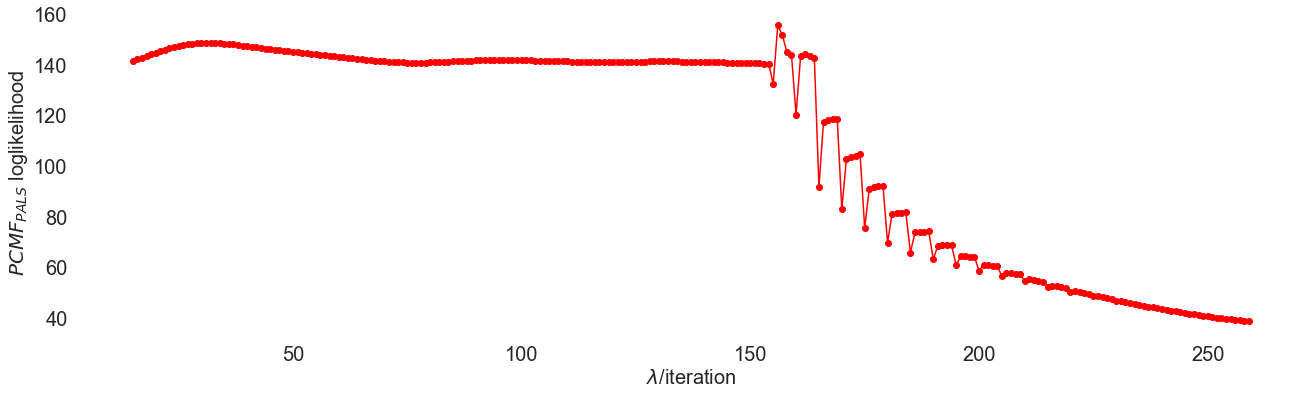

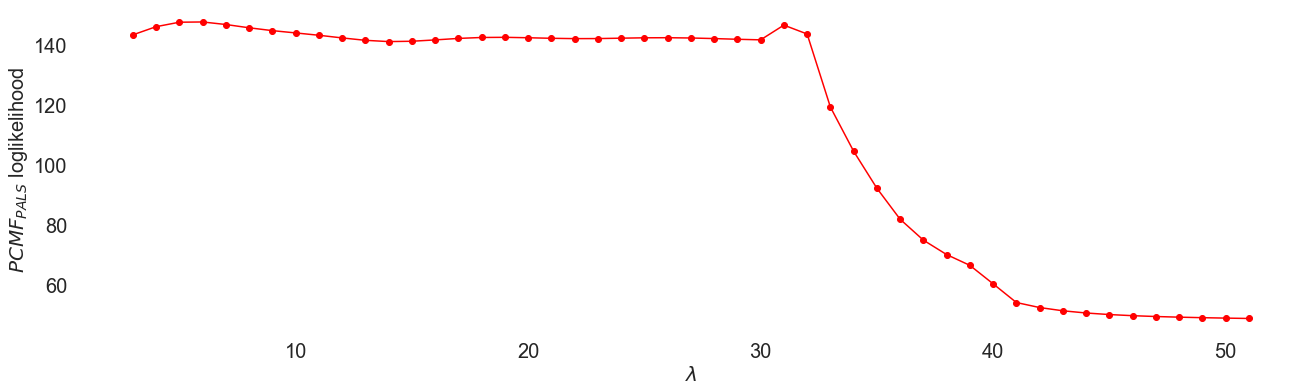

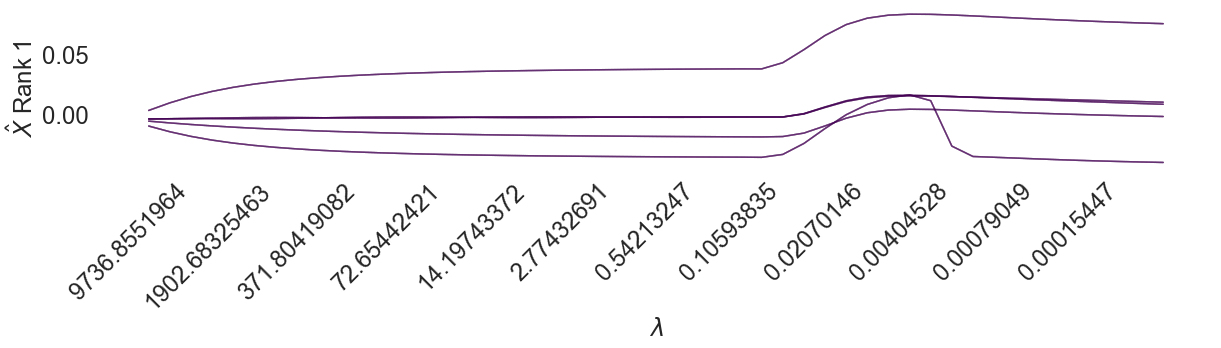

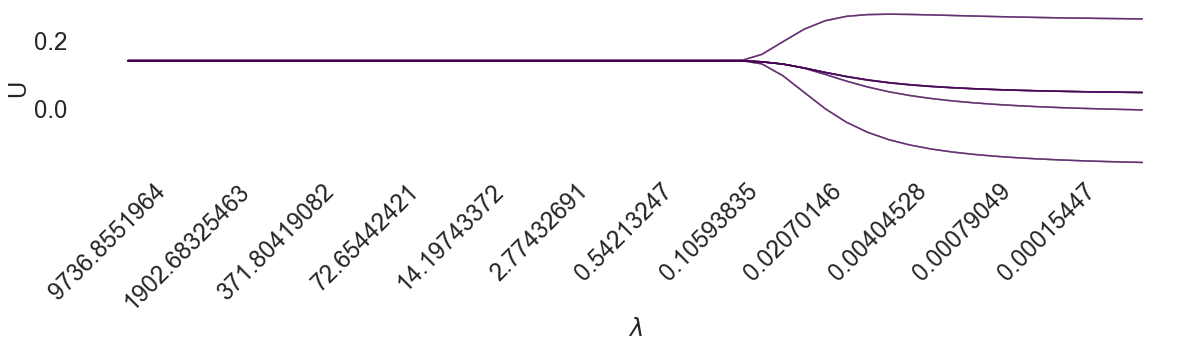

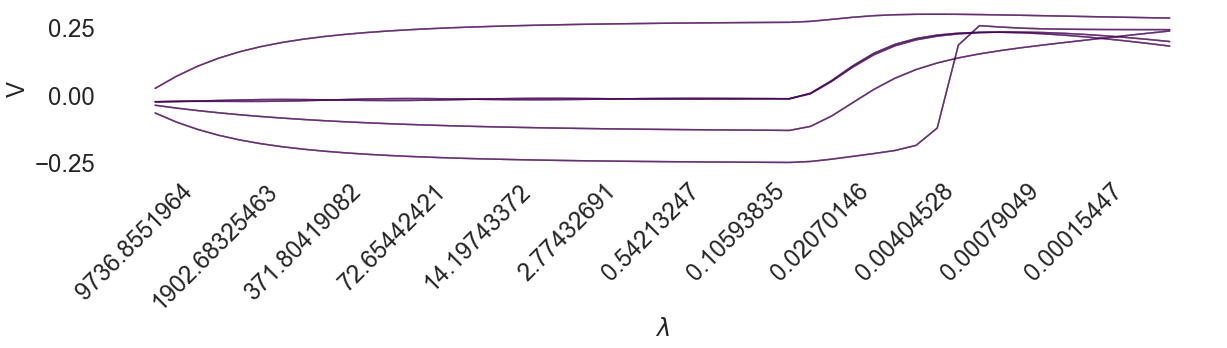

In [10]:
fontsize = 20

fig = plt.figure(figsize=(22,6))
ax = fig.add_subplot(111)
ax.patch.set_facecolor('white')
plt.xlabel('$\lambda$/iteration',fontsize=20)
plt.ylabel('$PCMF_{PALS}$ loglikelihood',fontsize=20)
plt.grid(b=None)
colors = cm.rainbow(np.linspace(1, 0, 2))
c = 0
P_list = []
for A,Z1,Z2 in zip(As_pals_its,Zs_pals_its,Z2s_pals_its):
    
    k_min = (n_infinities+1)*admm_iters; k_max = len(A)
    for k in np.arange(k_min,k_max,1):
        Xhat = A[k]
        Z1in = Z1[k]
        Z2in = Z2[k]
        penalty = penalty_list[int(np.floor(k / admm_iters))]
        P_list.append(np.linalg.norm(X - Xhat, 2)**2 + np.sum(np.sum(np.abs(Z1in), axis=1)) + np.sum(np.sum(np.abs(Z2in), axis=1)) )

    P = np.asarray(P_list)
    s = plt.plot(np.arange(k_min,k_max,1), P,'o-',color=colors[c,:])
    c = c+1

plt.xticks(fontsize=fontsize,rotation=0);
plt.yticks(fontsize=fontsize,rotation=0);


fig = plt.figure(figsize=(22,6))
ax = fig.add_subplot(111)
ax.patch.set_facecolor('white')
plt.xlabel('$\lambda$',fontsize=20)
plt.ylabel('$PCMF_{PALS}$ loglikelihood',fontsize=20)
plt.grid(b=None)
colors = cm.rainbow(np.linspace(1, 0, 52))
c = 0

for A,Z1,Z2 in zip(As_pals,Zs_pals,Z2s_pals):
    P_list = []
    k_min = n_infinities+1; k_max = len(A)
    for k in np.arange(k_min,k_max,1):
        Xhat = A[k]
        Z1in = Z1[k]
        Z2in = Z2[k]
        penalty = penalty_list[k]
        P_list.append(np.linalg.norm(X - Xhat, 2)**2 + np.sum(np.sum(np.abs(Z1in), axis=1)) + np.sum(np.sum(np.abs(Z2in), axis=1)) )

    P = np.asarray(P_list)
    s = plt.plot(np.arange(k_min,k_max,1), P,'o-',color=colors[c,:])
    c = c+1

plt.xticks(fontsize=fontsize,rotation=0);
plt.yticks(fontsize=fontsize,rotation=0);

for Xhat,V,U,problem_rank in zip(As_pals,Vs_pals,Us_pals,np.arange(1,max_rank)):
    plot_dendrogram(Xhat,problem_rank,true_clusters_all,n_infinities,penalty_list)
    plot_dendrogram(U,problem_rank,true_clusters_all,n_infinities,penalty_list,ylabel='U')
    plot_dendrogram(V,problem_rank,true_clusters_all,n_infinities,penalty_list,ylabel='V')




# ADMM 100 iterations

## PCMF ADMM

In [11]:
pcmf_type='pcmf_admm'
rho=1.0
weights='Gaussian'
gauss_coef=5.0
neighbors=25
admm_iters=100
n_infinities=10
penalty_list=np.concatenate((np.repeat(np.inf,n_infinities), np.exp(np.linspace(-10,10,50))[::-1]), axis=0)
split_size=X_all.shape[0]
parallel=False
save_path='nan'
max_rank = 10

As = []
Us = []
Ss = []
Vs = []
Gs = []
Z1s = []
Z2s = []
As_its = []
Gs_its = []
Z1s_its = []
Z2s_its = []
for problem_rank in range(1,max_rank):
    print('Problem rank '+str(problem_rank))
    tic=time.time()
    A, U, S, V, G, Z1, Z2, A_its, G_its, Z1_its, Z2_its = pcmf_full_consensus_its(X_all, penalty_list, split_size=split_size, rho=rho, admm_iters=admm_iters, weights=weights, gauss_coef=gauss_coef, problem_rank=problem_rank, neighbors=neighbors, print_progress=True, parallel=parallel, output_file=save_path+'.txt')
    As.append(A)
    Us.append(U)
    Ss.append(S)
    Vs.append(V)
    Gs.append(G)
    Z1s.append(Z1)
    Z2s.append(Z2)
    As_its.append(A_its)
    Gs_its.append(G_its)
    Z1s_its.append(Z1_its)
    Z2s_its.append(Z2_its)
    toc=time.time() - tic

Problem rank 1
weights: Gaussian neighbors: 25 gauss_coef: 5.0 rho: 1.0
rho1: 1.0 rho2 1.0
Number of batches: 1
Initialize IDX: 0
Means matrix has shape: (50, 11)
[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 2.20265e+04...[ 12 ] 1.46447e+04...[ 13 ] 9.73686e+03...[ 14 ] 6.47375e+03...[ 15 ] 4.30420e+03...[ 16 ] 2.86174e+03...[ 17 ] 1.90268e+03...[ 18 ] 1.26504e+03...[ 19 ] 8.41086e+02...[ 20 ] 5.59213e+02...[ 21 ] 3.71804e+02...[ 22 ] 2.47202e+02...[ 23 ] 1.64357e+02...[ 24 ] 1.09276e+02...[ 25 ] 7.26544e+01...[ 26 ] 4.83058e+01...[ 27 ] 3.21171e+01...[ 28 ] 2.13537e+01...[ 29 ] 1.41974e+01...[ 30 ] 9.43945e+00...[ 31 ] 6.27601e+00...[ 32 ] 4.17273e+00...[ 33 ] 2.77433e+00...[ 34 ] 1.84457e+00...[ 35 ] 1.22640e+00...[ 36 ] 8.15396e-01...[ 37 ] 5.42132e-01...[ 38 ] 3.60448e-01...[ 39 ] 2.39651e-01...[ 40 ] 1.59337e-01...[ 41 ] 1.05938e-01...[ 42 ] 7.04353e-02...[ 43 ] 4.68303e-02...[ 44 ] 3.11361e-02...[ 

[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 2.20265e+04...[ 12 ] 1.46447e+04...[ 13 ] 9.73686e+03...[ 14 ] 6.47375e+03...[ 15 ] 4.30420e+03...[ 16 ] 2.86174e+03...[ 17 ] 1.90268e+03...[ 18 ] 1.26504e+03...[ 19 ] 8.41086e+02...[ 20 ] 5.59213e+02...[ 21 ] 3.71804e+02...[ 22 ] 2.47202e+02...[ 23 ] 1.64357e+02...[ 24 ] 1.09276e+02...[ 25 ] 7.26544e+01...[ 26 ] 4.83058e+01...[ 27 ] 3.21171e+01...[ 28 ] 2.13537e+01...[ 29 ] 1.41974e+01...[ 30 ] 9.43945e+00...[ 31 ] 6.27601e+00...[ 32 ] 4.17273e+00...[ 33 ] 2.77433e+00...[ 34 ] 1.84457e+00...[ 35 ] 1.22640e+00...[ 36 ] 8.15396e-01...[ 37 ] 5.42132e-01...[ 38 ] 3.60448e-01...[ 39 ] 2.39651e-01...[ 40 ] 1.59337e-01...[ 41 ] 1.05938e-01...[ 42 ] 7.04353e-02...[ 43 ] 4.68303e-02...[ 44 ] 3.11361e-02...[ 45 ] 2.07015e-02...[ 46 ] 1.37638e-02...[ 47 ] 9.15113e-03...[ 48 ] 6.08432e-03...[ 49 ] 4.04528e-03...[ 50 ] 2.68959e-03...[ 51 ] 1.78823e-03...[ 52 ] 1.18894e-03

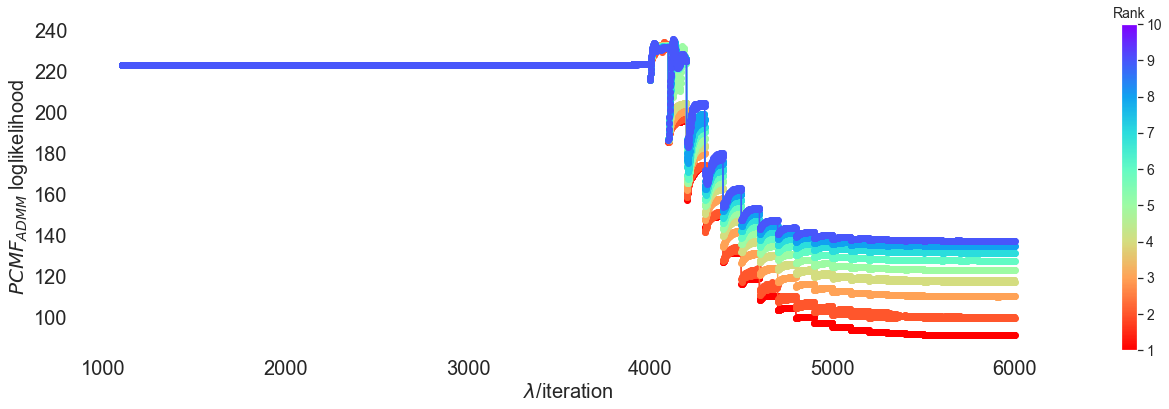

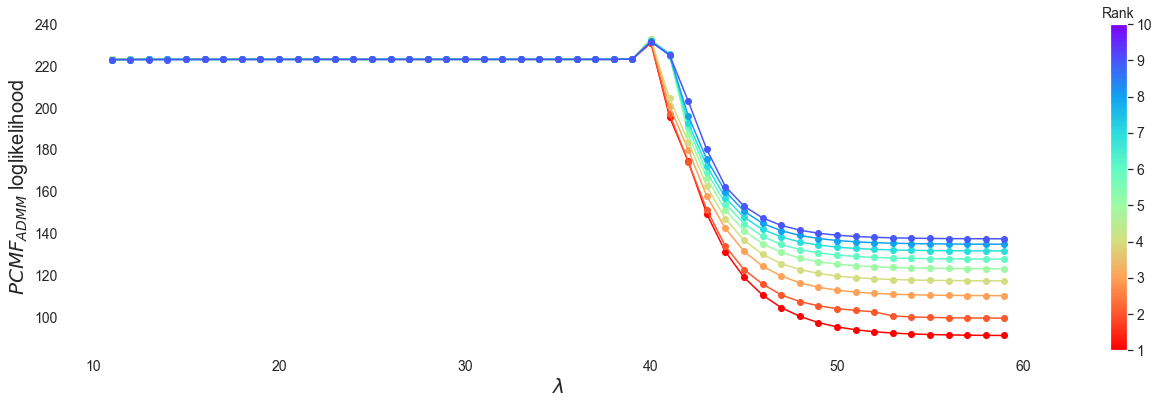

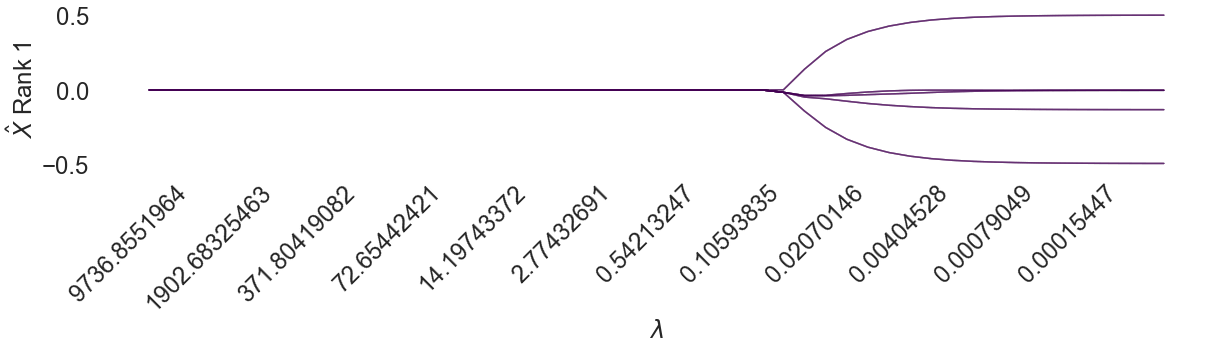

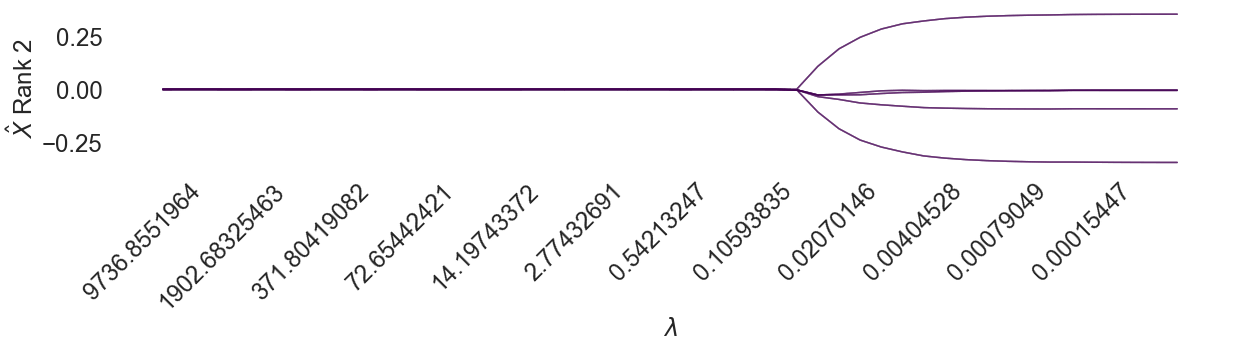

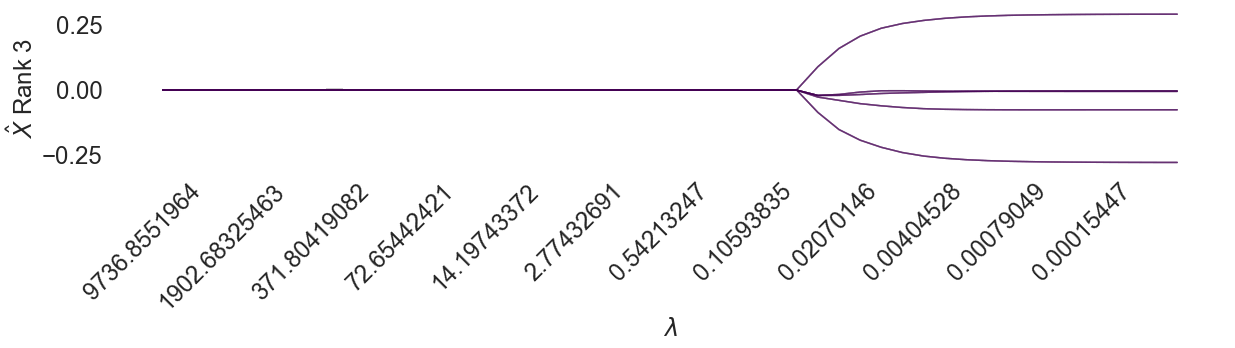

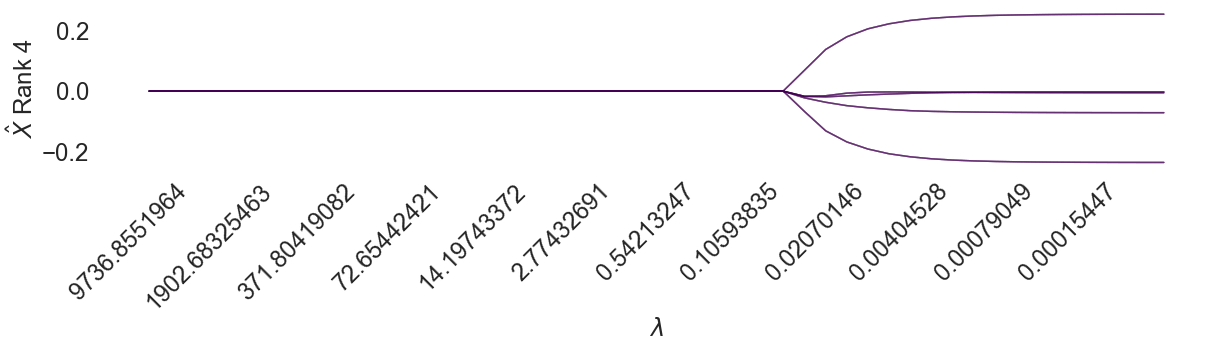

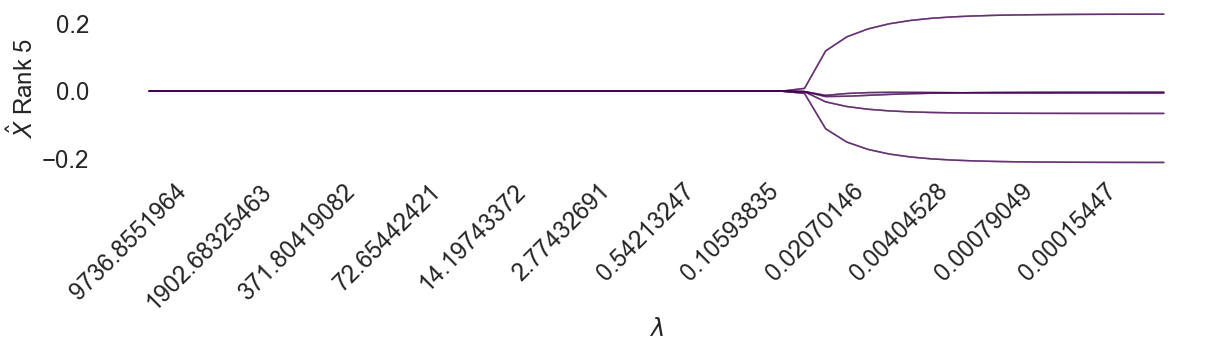

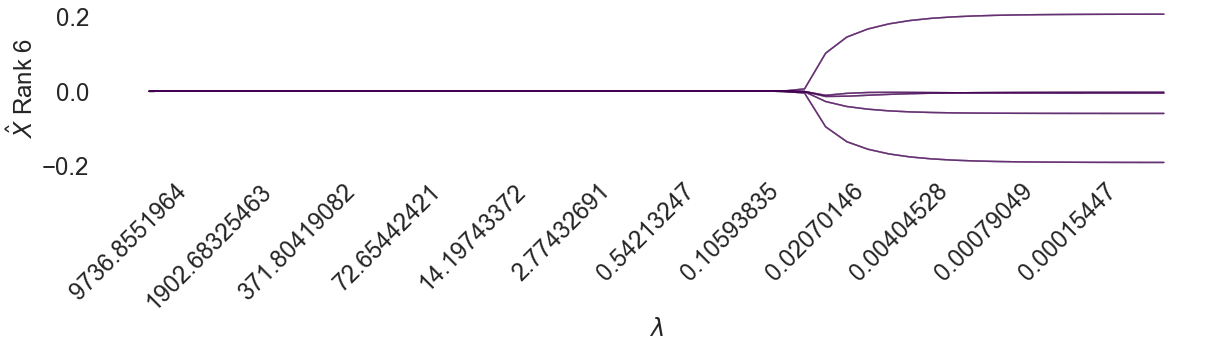

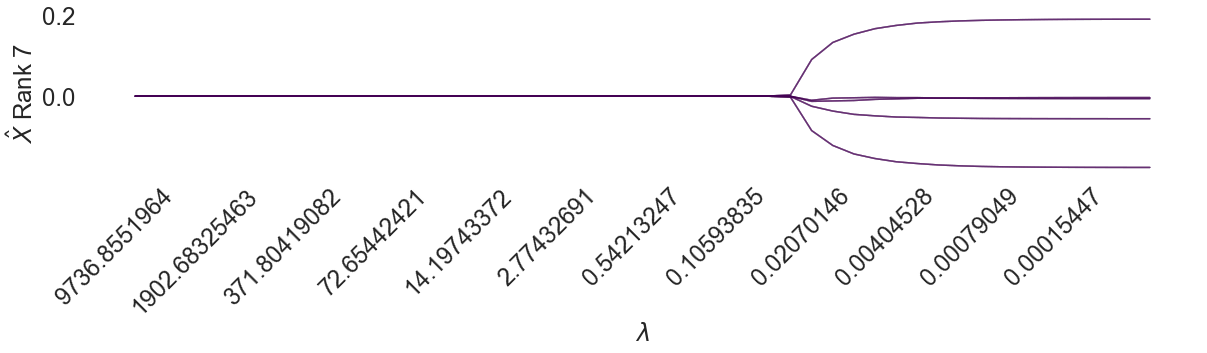

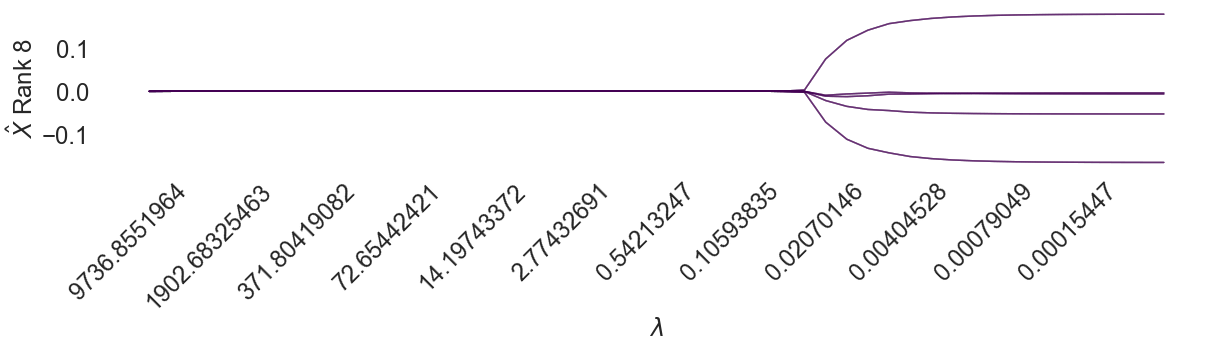

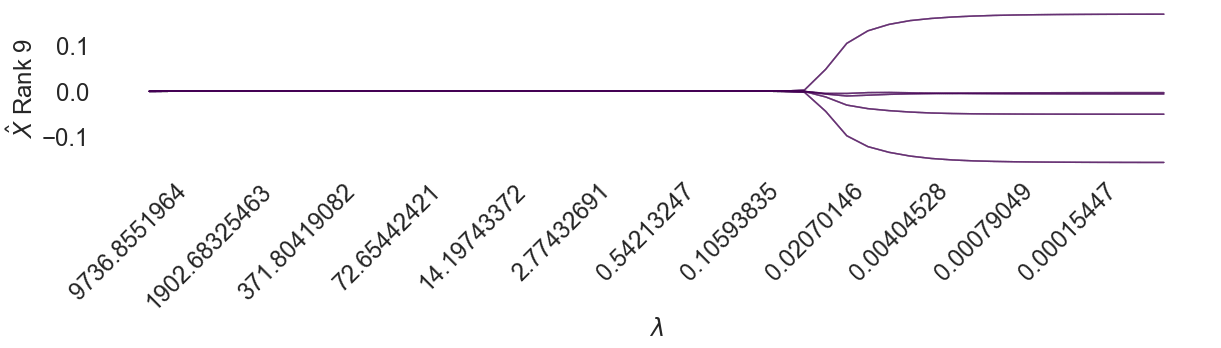

In [12]:
fontsize=20

fig = plt.figure(figsize=(22,6))
ax = fig.add_subplot(111)
ax.patch.set_facecolor('white')
plt.xlabel('$\lambda$/iteration',fontsize=20)
plt.ylabel('$PCMF_{ADMM}$ loglikelihood',fontsize=20)
plt.grid(b=None)
colors = cm.rainbow(np.linspace(1, 0, max_rank))
c = 0

for A,G,Z1,Z2 in zip(As_its,Gs_its,Z1s_its,Z2s_its):
    P_list = []
    k_min = (n_infinities+1)*admm_iters; k_max = len(A)
    for k in np.arange(k_min,k_max,1):
        Xhat = A[k]
        Z1in = Z1[k]
        Z2in = Z2[k]
        penalty = penalty_list[int(np.floor(k / admm_iters))]
        P_list.append(np.linalg.norm(X -Xhat, 2)**2 + np.sum(np.sum(np.abs(Z1in), axis=1)) + np.sum(np.sum(np.abs(Z2in), axis=1)) )# np.linalg.norm(Z1in, 2)**2 + np.linalg.norm(Z2in, 2)**2)
    P = np.asarray(P_list)
    s = plt.plot(np.arange(k_min,k_max,1), P,'o-',color=colors[c,:])
    c = c+1

plt.xticks(fontsize=fontsize,rotation=0);
plt.yticks(fontsize=fontsize,rotation=0);
fontsize=14
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('colors',colors)
sm = plt.cm.ScalarMappable(cmap=mymap, norm=plt.Normalize(vmin=1, vmax=max_rank ))
cbar = plt.colorbar(sm)
cbar.ax.set_title('Rank', rotation=0, fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)


fig = plt.figure(figsize=(22,6))
ax = fig.add_subplot(111)
ax.patch.set_facecolor('white')
plt.xlabel('$\lambda$',fontsize=20)
plt.ylabel('$PCMF_{ADMM}$ loglikelihood',fontsize=20)
plt.grid(b=None)
c = 0

for A,Z1,Z2 in zip(As,Z1s,Z2s):
    P_list = []
    k_min = n_infinities+1; k_max = len(A)
    for k in np.arange(k_min,k_max,1):
        Xhat = A[k]
        Z1in = Z1[k]
        Z2in = Z2[k]
        penalty = penalty_list[k]
        P_list.append(np.linalg.norm(X -Xhat, 2)**2 + np.sum(np.sum(np.abs(Z1in), axis=1)) + np.sum(np.sum(np.abs(Z2in), axis=1)) )

    P = np.asarray(P_list)
    s = plt.plot(np.arange(k_min,k_max,1), P,'o-',color=colors[c,:])
    c = c+1

plt.xticks(fontsize=fontsize,rotation=0);
plt.yticks(fontsize=fontsize,rotation=0);

mymap = matplotlib.colors.LinearSegmentedColormap.from_list('colors',colors)
sm = plt.cm.ScalarMappable(cmap=mymap, norm=plt.Normalize(vmin=1, vmax=max_rank ))
cbar = plt.colorbar(sm)
cbar.ax.set_title('Rank', rotation=0, fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

for Xhat,problem_rank in zip(As,np.arange(1,max_rank)):
    plot_dendrogram(Xhat,problem_rank,true_clusters_all,n_infinities,penalty_list)





## PCMF PALS

In [13]:
pcmf_type='pcmf_pals'
rho=1.0
weights='Gaussian'
gauss_coef=5.0
neighbors=25
admm_iters=100
n_infinities=2
penalty_list=np.concatenate((np.repeat(np.inf,n_infinities), np.exp(np.linspace(-10,10,50))[::-1]), axis=0)
split_size=X_all.shape[0]
parallel=False
save_path='nan'

As_pals = []
Us_pals = []
Ss_pals = []
Vs_pals = []
Ws_pals = []
W2s_pals = []
Zs_pals = []
Z2s_pals = []
Xvs_pals = []
Xus_pals = []
Us_pals_its = []
Vs_pals_its = []
Zs_pals_its = []
Z2s_pals_its = []
As_pals_its = []
for problem_rank in range(1):
    tic=time.time()
    V_pals, U_pals, S_pals, W_pals, W2_pals, Z_pals, Z2_pals, Xv_pals, Xu_pals, U_pals_its, V_pals_its, Z_pals_its, Z2_pals_its = pcmf_approx_uV_its(X_all, penalty_list, numba=True, rho=rho, pals_admm=True,admm_iters=admm_iters, weights=weights, gauss_coef=gauss_coef, neighbors=neighbors, print_progress=True, parallel=parallel, output_file=save_path+'.txt')
    A_pals = []
    for p in range(len(penalty_list)):
        A_pals.append(U_pals[p]*V_pals[p])
    A_pals_its = []
    for it in range(len(U_pals_its)):
        A_pals_its.append(U_pals_its[it]*V_pals_its[it])

    As_pals.append(A_pals)
    Us_pals.append(U_pals)
    Ss_pals.append(S_pals)
    Vs_pals.append(V_pals)
    Ws_pals.append(W_pals)
    W2s_pals.append(W2_pals)
    Zs_pals.append(Z_pals)
    Z2s_pals.append(Z2_pals)
    Xvs_pals.append(Xv_pals)
    Xus_pals.append(Xu_pals)
    Us_pals_its.append(U_pals_its)
    Vs_pals_its.append(V_pals_its)
    Zs_pals_its.append(Z_pals_its)
    Z2s_pals_its.append(Z2_pals_its)
    As_pals_its.append(A_pals_its)
    
    toc=time.time() - tic


weights: Gaussian neighbors: 25 gauss_coef: 5.0 rho: 1.0
[ 1 ] inf...[ 2 ] inf...[ 3 ] 2.20265e+04...[ 4 ] 1.46447e+04...[ 5 ] 9.73686e+03...[ 6 ] 6.47375e+03...[ 7 ] 4.30420e+03...[ 8 ] 2.86174e+03...[ 9 ] 1.90268e+03...[ 10 ] 1.26504e+03...[ 11 ] 8.41086e+02...[ 12 ] 5.59213e+02...[ 13 ] 3.71804e+02...[ 14 ] 2.47202e+02...[ 15 ] 1.64357e+02...[ 16 ] 1.09276e+02...[ 17 ] 7.26544e+01...[ 18 ] 4.83058e+01...[ 19 ] 3.21171e+01...[ 20 ] 2.13537e+01...[ 21 ] 1.41974e+01...[ 22 ] 9.43945e+00...[ 23 ] 6.27601e+00...[ 24 ] 4.17273e+00...[ 25 ] 2.77433e+00...[ 26 ] 1.84457e+00...[ 27 ] 1.22640e+00...[ 28 ] 8.15396e-01...[ 29 ] 5.42132e-01...[ 30 ] 3.60448e-01...[ 31 ] 2.39651e-01...[ 32 ] 1.59337e-01...[ 33 ] 1.05938e-01...[ 34 ] 7.04353e-02...[ 35 ] 4.68303e-02...[ 36 ] 3.11361e-02...[ 37 ] 2.07015e-02...[ 38 ] 1.37638e-02...[ 39 ] 9.15113e-03...[ 40 ] 6.08432e-03...[ 41 ] 4.04528e-03...[ 42 ] 2.68959e-03...[ 43 ] 1.78823e-03...[ 44 ] 1.18894e-03...[ 45 ] 7.90490e-04...[ 46 ] 5.25574e-04...[ 

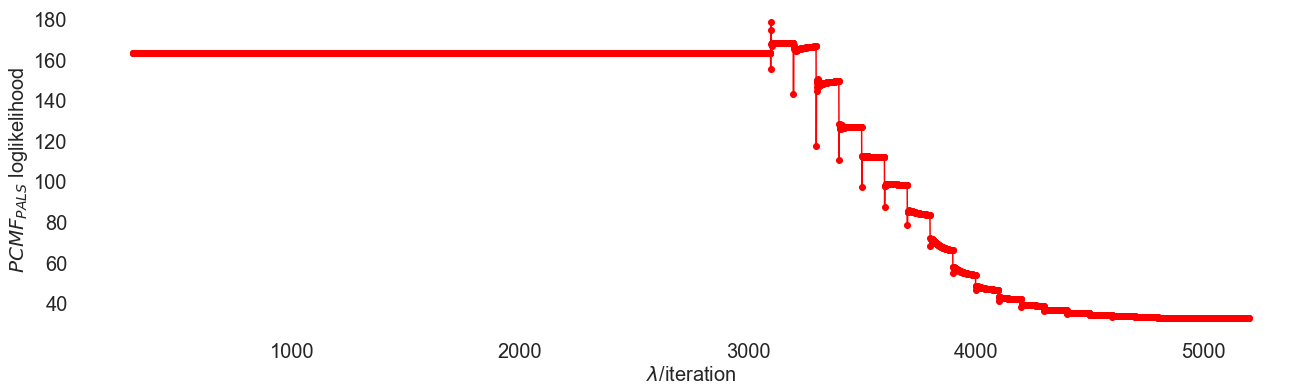

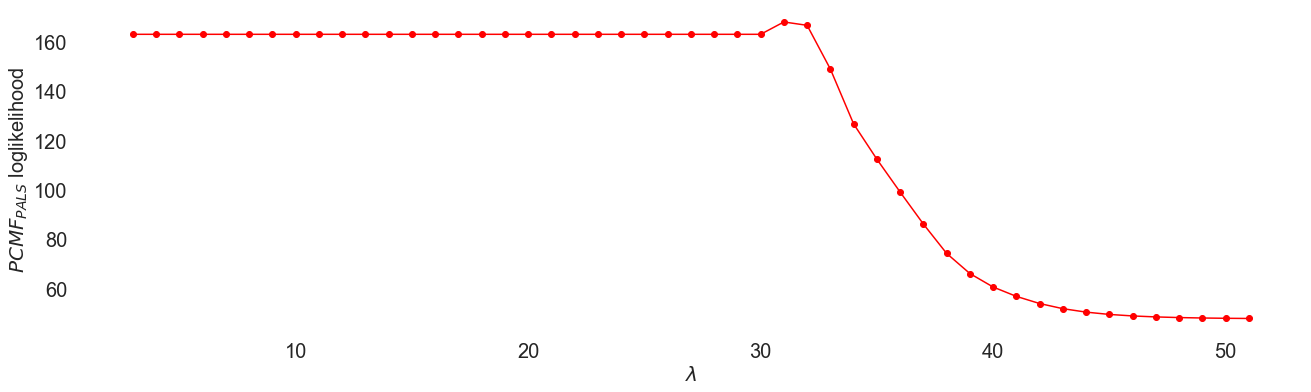

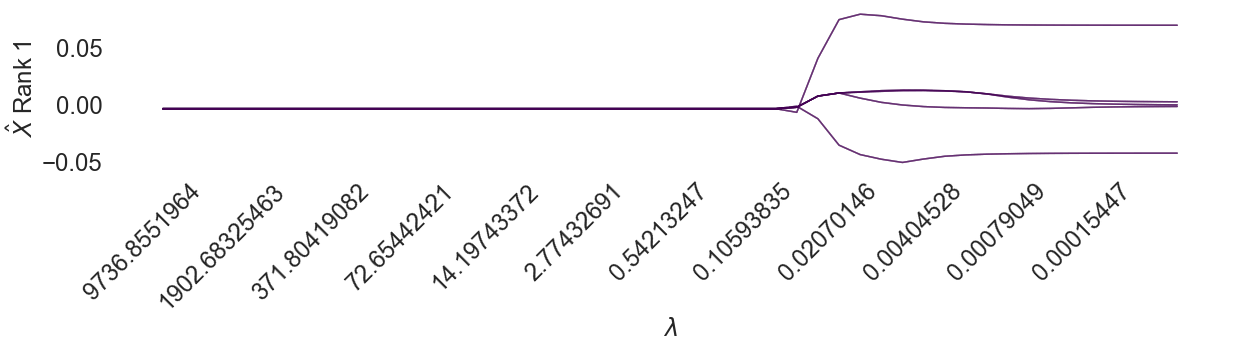

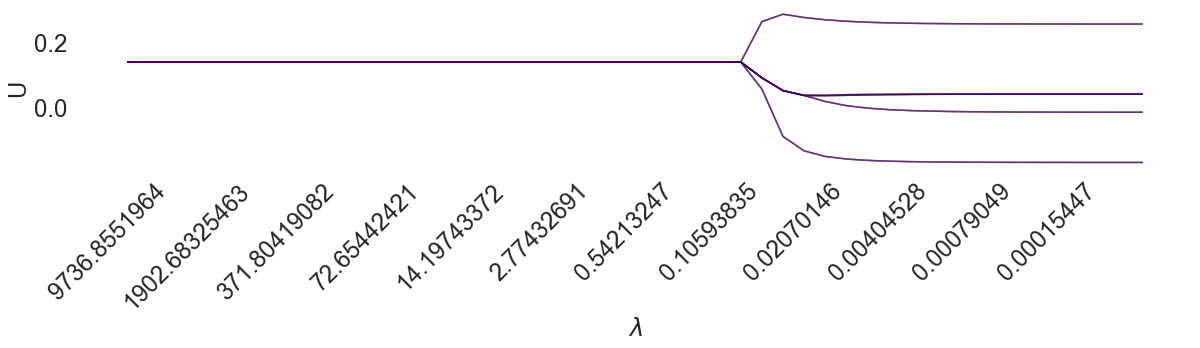

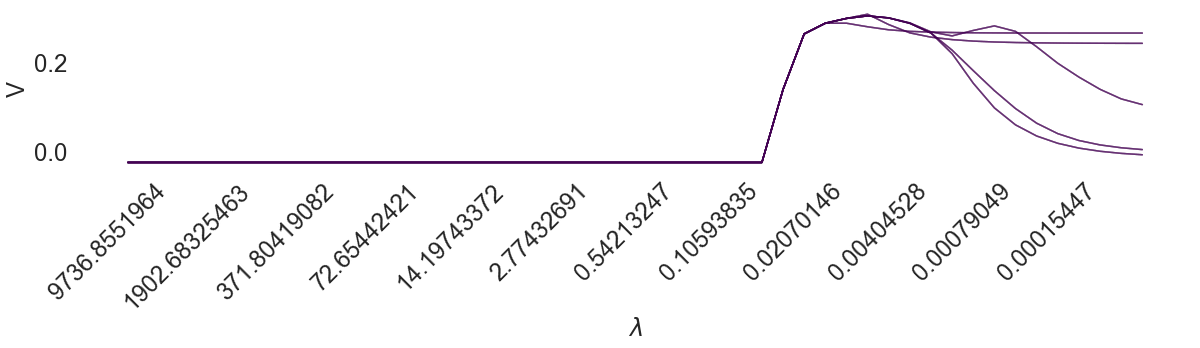

In [14]:
fontsize = 20

fig = plt.figure(figsize=(22,6))
ax = fig.add_subplot(111)
ax.patch.set_facecolor('white')
plt.xlabel('$\lambda$/iteration',fontsize=20)
plt.ylabel('$PCMF_{PALS}$ loglikelihood',fontsize=20)
plt.grid(b=None)
colors = cm.rainbow(np.linspace(1, 0, 2))
c = 0
P_list = []
for A,Z1,Z2 in zip(As_pals_its,Zs_pals_its,Z2s_pals_its):
    
    k_min = (n_infinities+1)*admm_iters; k_max = len(A)
    for k in np.arange(k_min,k_max,1):
        Xhat = A[k]
        Z1in = Z1[k]
        Z2in = Z2[k]
        penalty = penalty_list[int(np.floor(k / admm_iters))]
        P_list.append(np.linalg.norm(X -Xhat, 2)**2 + np.sum(np.sum(np.abs(Z1in), axis=1)) + np.sum(np.sum(np.abs(Z2in), axis=1)) )

    P = np.asarray(P_list)
    s = plt.plot(np.arange(k_min,k_max,1), P,'o-',color=colors[c,:])
    c = c+1

plt.xticks(fontsize=fontsize,rotation=0);
plt.yticks(fontsize=fontsize,rotation=0);


fig = plt.figure(figsize=(22,6))
ax = fig.add_subplot(111)
ax.patch.set_facecolor('white')
plt.xlabel('$\lambda$',fontsize=20)
plt.ylabel('$PCMF_{PALS}$ loglikelihood',fontsize=20)
plt.grid(b=None)
colors = cm.rainbow(np.linspace(1, 0, 52))
c = 0

for A,Z1,Z2 in zip(As_pals,Zs_pals,Z2s_pals):
    P_list = []
    k_min = n_infinities+1; k_max = len(A)
    for k in np.arange(k_min,k_max,1):
        Xhat = A[k]
        Z1in = Z1[k]
        Z2in = Z2[k]
        penalty = penalty_list[k]
        P_list.append(np.linalg.norm(X -Xhat, 2)**2 + np.sum(np.sum(np.abs(Z1in), axis=1)) + np.sum(np.sum(np.abs(Z2in), axis=1)) )

    P = np.asarray(P_list)
    s = plt.plot(np.arange(k_min,k_max,1), P,'o-',color=colors[c,:])
    c = c+1

plt.xticks(fontsize=fontsize,rotation=0);
plt.yticks(fontsize=fontsize,rotation=0);

for Xhat,V,U,problem_rank in zip(As_pals,Vs_pals,Us_pals,np.arange(1,max_rank)):
    plot_dendrogram(Xhat,problem_rank,true_clusters_all,n_infinities,penalty_list)
    plot_dendrogram(U,problem_rank,true_clusters_all,n_infinities,penalty_list,ylabel='U')
    plot_dendrogram(V,problem_rank,true_clusters_all,n_infinities,penalty_list,ylabel='V')


